In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import normaltest
from scipy.stats import norm
from scipy.stats import skew
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import re
import warnings
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from wordcloud import WordCloud, STOPWORDS 
warnings.filterwarnings('ignore')
%matplotlib inline

data = pd.read_csv('/content/drive/MyDrive/Data Science Tutorials/CarPrice.csv')
data.head()


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
print(data.shape)
print(data.columns)
print(data.dtypes)

(205, 26)
Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')
car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    f

I guess we don't need car_ID and symboling columns and get categorical and numerical columns:

In [4]:
data = data.drop('car_ID', 1)
data = data.drop('symboling', 1)

Take a look at the values and try to find the missing one

In [5]:
for column in data:
    print("\n" + column + ":" + str(data[column].isnull().sum()))
    


CarName:0

fueltype:0

aspiration:0

doornumber:0

carbody:0

drivewheel:0

enginelocation:0

wheelbase:0

carlength:0

carwidth:0

carheight:0

curbweight:0

enginetype:0

cylindernumber:0

enginesize:0

fuelsystem:0

boreratio:0

stroke:0

compressionratio:0

horsepower:0

peakrpm:0

citympg:0

highwaympg:0

price:0


It looks like we don't have missing data.

Before we will start to analyse relationship between variables, we need to take a look at our dependent variable 'price'. We want it to be without outliers and also it's distribution being approximately normal .
First, take a look if there any ouliers:

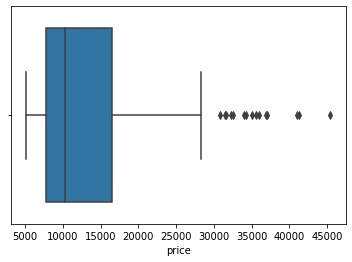

In [6]:
sns.boxplot(x=data['price'])

It looks like we have here some outliers. Let's use z-score to check which obsrvation we can call 'outlier'. The data with z-score > 3 or < -3 should be considered as outliers:

In [7]:
z_score = stats.zscore(data['price'])
outlier = data[np.abs(z_score) > 3]
print(outlier)

                            CarName fueltype  ... highwaympg    price
16                           bmw x5      gas  ...         22  41315.0
73            buick century special      gas  ...         16  40960.0
74  buick regal sport coupe (turbo)      gas  ...         16  45400.0

[3 rows x 24 columns]


so we have 3 observations which we can call outliers. Maybe we would need to remove it, but if we try to understand why this cars is so expensive, we would take a look at the rows above and see that there are two buicks and one BMX x5, they are usually quite exepensive cars, so probably it's not really a 'wrong' data, they are just small amount of really expensive cars, but they shouldn't effect on the accuracy of our model.

Now let's analyse prices, take a look at how it looks like. First - take a look at distribution plot:

AxesSubplot(0.125,0.125;0.775x0.755)


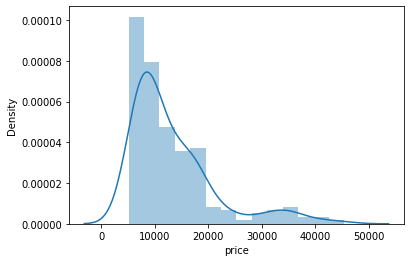

In [8]:
print(sns.distplot(data['price']))

The plot above shows that the distribution is skewed, so we will apply log-transformation:

AxesSubplot(0.125,0.125;0.775x0.755)


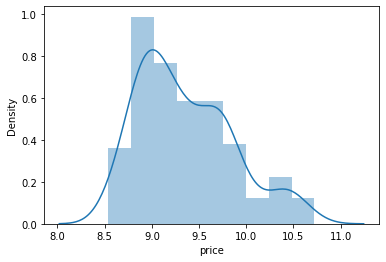

In [9]:
data['price'] = np.log1p(data['price'])
print(sns.distplot(data['price']))

Now distribution of the car prices looks much more normal.

On the next step we will investigate the relationship between variables:

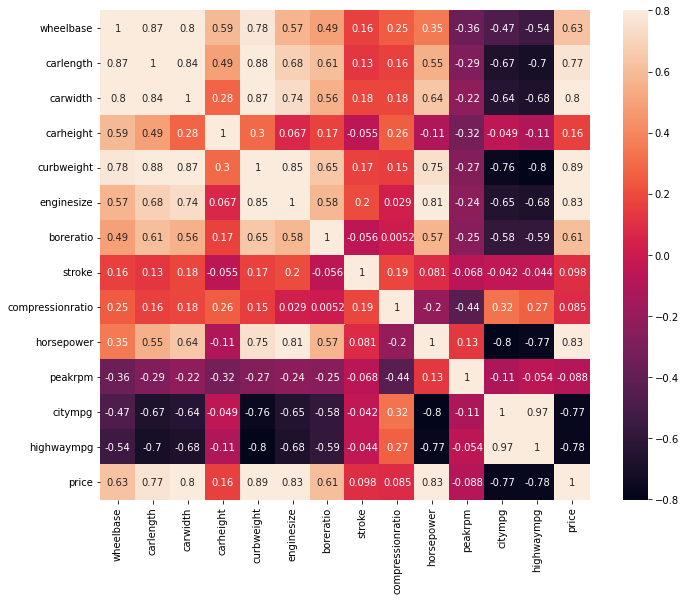

In [10]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, annot_kws={'size': 10}, annot = True, square=True);

From this matrix we can see that price variable has strong positive correlation with variables: enginesize, curbweight, horsepower, carwidth, carlength, wheelbase and boreratio. There is also multicollinearity exist here: in correlation matrix above we can see that there is correlation between these variables. Price is also negativly correlated with citympg and highwaympg (which are also have strong positive correlation with each other and negative correlation with some of other variables, which were mentioned above). 

Let's take a look at the plot of the enginesize variable, which is most correlated to price:

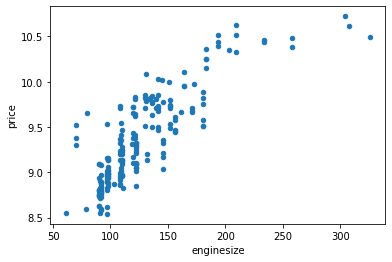

In [11]:
data.plot.scatter(x='enginesize', y='price');

Looking at the plot above we can see strong relashionship between variables.


Previous analysis shows us that there are few variables which have correlation between each other and also correlated with price. Let's try to reduce amount of predictors using principle component analysis. To do PCA we need first to standardize the data:

In [12]:
pca_columns = ["enginesize", "curbweight", "horsepower", 
               "carwidth", "carlength", "wheelbase", 
               "boreratio", "citympg", "highwaympg"]
pca_columns
data_pca = data[pca_columns]
#data_train.head()
#standardizing data
StandardScaler().fit_transform(data_pca)
data_pca.head()

,enginesize,curbweight,horsepower,carwidth,carlength,wheelbase,boreratio,citympg,highwaympg
0,130,2548,111,64.1,168.8,88.6,3.47,21,27
1,130,2548,111,64.1,168.8,88.6,3.47,21,27
2,152,2823,154,65.5,171.2,94.5,2.68,19,26
3,109,2337,102,66.2,176.6,99.8,3.19,24,30
4,136,2824,115,66.4,176.6,99.4,3.19,18,22


And then let's get first 2 principal components in principal component analysis: 

In [13]:
from sklearn.decomposition import PCA
pca_train = PCA(n_components=2)
principal_components = pca_train.fit_transform(data_pca)
pca_train.explained_variance_ratio_

array([0.99548045, 0.00323041])

In [14]:
principal_data = pd.DataFrame(data = principal_components, columns = ['pca_1', 'pca_2'])
principal_data.head()

,pca_1,pca_2
0,-7.057267,9.466968
1,-7.057267,9.466968
2,270.841223,33.378201
3,-218.880370,6.379076
4,268.738449,-7.936346


PCA allows us to use 1 variable (principal component) instead of 9 numeric variables which were correlated to price and to each other and loose only 0.3% of information contained in these variables.

AxesSubplot(0.125,0.125;0.775x0.755)


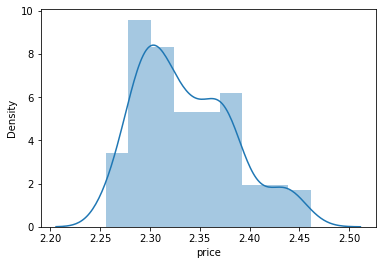

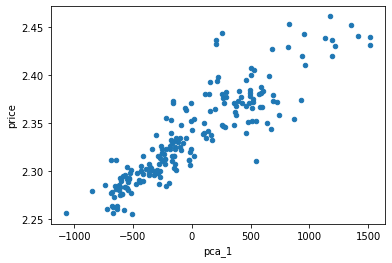

In [15]:
data['price'] = np.log1p(data['price'])
print(sns.distplot(data['price']))
principal_data['price'] = data['price']
principal_data.head()
principal_data.plot.scatter(x='pca_1', y='price');


We can see a few points (they have 2.4<price<2.45 AND 0<PCA<500), potencially it could influential point, but because result of principal component analysis is not very easy interpretable, let's keep this points in mind and will check it when we will building regression model.


AxesSubplot(0.125,0.125;0.775x0.755)


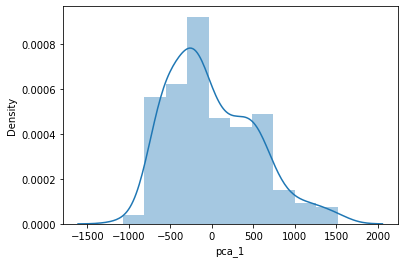

In [16]:
print(sns.distplot(principal_data['pca_1']))

Correlation matrix showed us that the rest of numeric variables don't have linear relationship with car price, but who knows may be they have non-linear relatioship with the price?

In [17]:
#remove numeric variables which we already used in PCA
data_rest = data._get_numeric_data()
data_rest.drop(pca_columns, axis=1, inplace = True)
data_rest.head()

,carheight,stroke,compressionratio,peakrpm,price
0,48.8,2.68,9.0,5000,2.352341
1,48.8,2.68,9.0,5000,2.371288
2,52.4,3.47,9.0,5000,2.371288
3,54.3,3.40,10.0,5500,2.355491
4,54.3,3.40,8.0,5500,2.376500


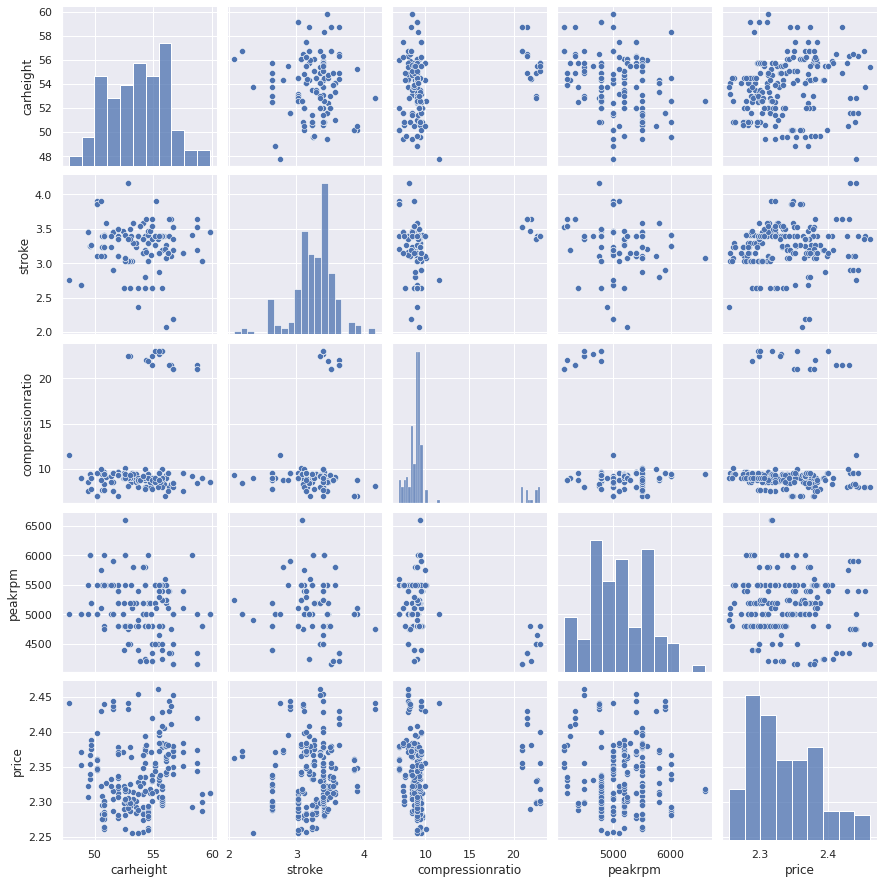

In [18]:
#scatterplot
sns.set()
sns.pairplot(data_rest, size = 2.5)
plt.show()

I don't see any pattern on the plots so indeed there are no any relationships between this variables and car price variable.

So continuing analysis with categorical variables, there are a lot of them. We will convert them into dummy variables and try to understand which ones we should use in modelling:

In [19]:
dummy_data = data.select_dtypes(include=['object'])
dummy_data = dummy_data.drop('CarName', 1)
dummy_data.head()

,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [20]:
dummy_data = pd.get_dummies(dummy_data)
print(dummy_data.shape)

(205, 38)


Now we can construct a correlation matrix for these variables and price:


In [21]:
dummy_data = pd.concat([data['price'], dummy_data], axis=1)

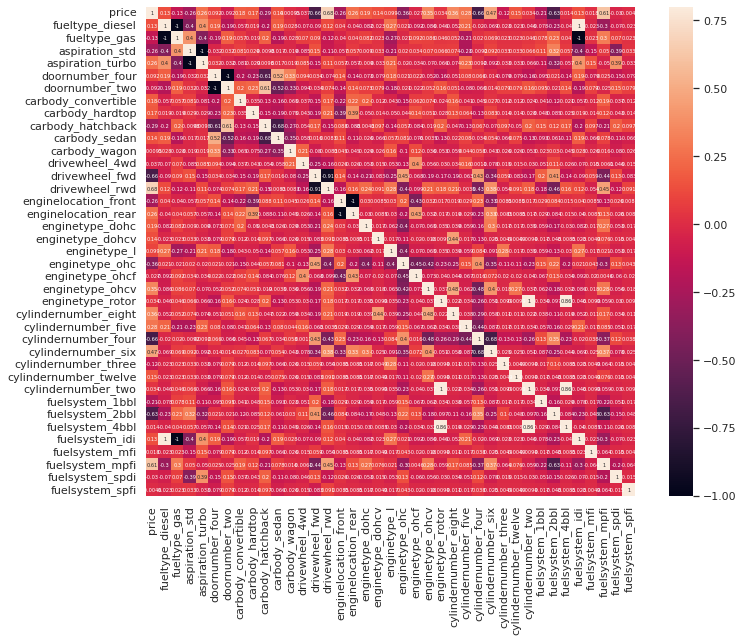

In [22]:
corrmat_dummy = dummy_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_dummy, vmax=.8, annot_kws={'size': 5}, annot = True, square=True);

Correlation matrix above is difficult to read, let's make smaller one: we will filter and show only the values which means linear relationship with price (correlation coefficient with price should be > 0.5 or < -0.5):

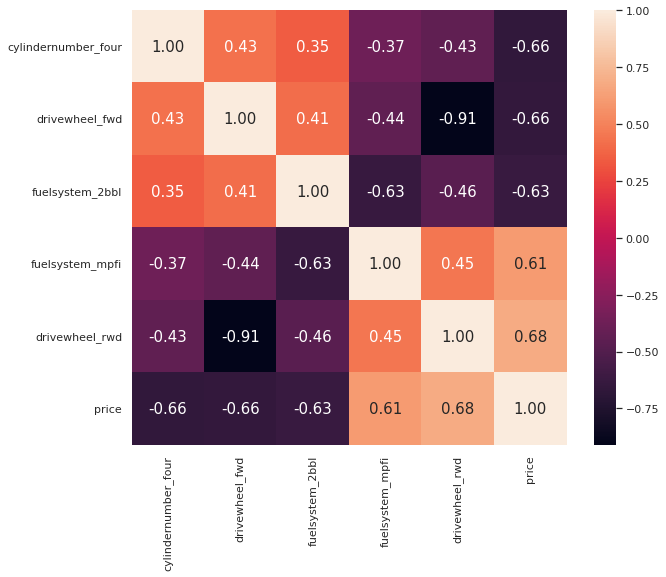

In [23]:
positive_corr = corrmat_dummy.sort_values('price', )[corrmat_dummy['price']>0.5]['price']
negatie_corr =  corrmat_dummy.sort_values('price', )[corrmat_dummy['price']<-0.5]['price']
correlated_dummy_cols = pd.concat([negatie_corr,positive_corr], axis=0).index
cm = np.corrcoef(dummy_data[correlated_dummy_cols].values.T)
f, ax = plt.subplots(figsize=(10, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=correlated_dummy_cols.values, xticklabels=correlated_dummy_cols.values)
plt.show()

It looks like price have strong linear relationship with these variables: 'cylindernumber_four', 'drivewheel_fwd', 'fuelsystem_2bbl','fuelsystem_mpfi' and 'drivewheel_rwd'. Let's take a look at the plot with most correlated variable: 

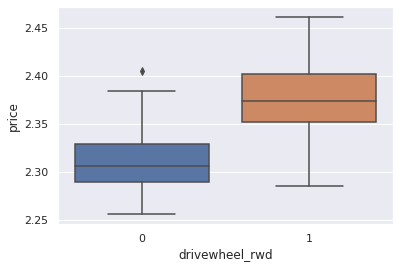

In [24]:
sns.boxplot(x='drivewheel_rwd', y="price", data = dummy_data)

Indeed we can see some relationship here. From the correlation matrix we also can see that variables 'drivewheel_fwd' and 'drivewheel_rwd' have strong negative correlation, so to avoid multicollinearity we will use only one of them (drivewheel_rwd).

Then let's construct new data frame, which we will use to train our model. It would contain correlated dummy variables and principal component. 
First, remove all the numeric variables we used in PCA (we will replace them with first principal component):

In [25]:
correlated_dummy_cols = correlated_dummy_cols.drop('drivewheel_fwd')
data_to_model = pd.concat([principal_data['pca_1'], dummy_data[correlated_dummy_cols]], axis=1)
data_to_model.head()

,pca_1,cylindernumber_four,fuelsystem_2bbl,fuelsystem_mpfi,drivewheel_rwd,price
0,-7.057267,1,0,1,1,2.352341
1,-7.057267,1,0,1,1,2.371288
2,270.841223,0,0,1,1,2.371288
3,-218.880370,1,0,1,0,2.355491
4,268.738449,0,0,1,0,2.376500


# Fit linear regression models

### Simple Linear Regression

Now we can start fitting a models for our data to predict car prices and choose the best one. First we will define a function for split the dataframe to  train and test subsets:

In [26]:
import sklearn.model_selection as model_selection

def split_data(data_to_model, pred, random_state):
    data_train, data_test, y_train, y_test = model_selection.train_test_split(data_to_model, pred,
                                                                              train_size=0.7,
                                                                              test_size=0.3, 
                                                                              random_state=random_state)
    print(data_train.shape)
    print(data_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    return data_train, data_test, y_train, y_test

And also the function for calculation adjustment R squared (to check the quality of the model):

In [27]:
from sklearn.metrics import r2_score

def adjusted_r2(r2_score, n, p):
    len_score = (n-1)/(n-p-1)
    score = (1 - r2_score) * len_score
    return 1- score

Let's start building the models. We are going to try build model only with first principal component and see whether adding categorical variables would make our model better:

In [28]:
from sklearn.linear_model import LinearRegression

pred = data_to_model['price']
pc1_data = pd.DataFrame(data = data_to_model['pca_1'], columns = ['pca_1'])

data_train, data_test, y_train, y_test = split_data(pc1_data, pred, random_state = 303)
lmPCA = LinearRegression()
lmPCA.fit(data_train,y_train)

print(lmPCA.intercept_)
print(lmPCA.coef_)

y_train_pred = lmPCA.predict(data_train)

print(r2_score(y_train,y_train_pred))
print(adjusted_r2(r2_score(y_train,y_train_pred), len(data_train), len(data_train.columns)))


(143, 1)
(62, 1)
(143,)
(62,)
2.33507732696217
[8.26210978e-05]
0.8122738803731482
0.8109424894538089


We can see that this model explains 81% of the variance of the data. 

### Simple Linear Regression without possible inflation points

We also still keep im mind that we have possible outliers, which we saw above on the price/PCA_1 sctterplot. Let's define them, remove and build a model without them to see will it be better:

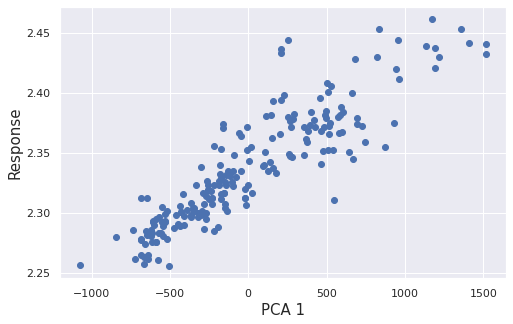

In [29]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=data_to_model['pca_1'],y=data_to_model['price'])
plt.xlabel("PCA 1",fontsize=15)
plt.ylabel("Response",fontsize=15)
plt.show()

In [30]:
possible_outliers_1 = data_to_model[(data_to_model['pca_1']>0) & (data_to_model['pca_1']<500) & (data_to_model['price'] > 2.4) & (data_to_model['price'] < 2.45)].index
print(possible_outliers_1)
possible_outlier_2 = data_to_model[(data_to_model['pca_1']>500) & (data_to_model['pca_1']<1000) & (data_to_model['price'] >2.3) & (data_to_model['price'] < 2.325)].index
print(possible_outlier_2)


Int64Index([126, 127, 128], dtype='int64')
Int64Index([155], dtype='int64')


In [31]:
data_to_model.drop(possible_outliers_1, axis=0, inplace = True)
data_to_model.drop(possible_outlier_2, axis=0, inplace = True)

pred = data_to_model['price']
pc1_data = pd.DataFrame(data = data_to_model['pca_1'], columns = ['pca_1'])

data_train, data_test, y_train, y_test = split_data(pc1_data, pred, random_state = 303)
lmPCA = LinearRegression()
lmPCA.fit(data_train,y_train)

print(lmPCA.intercept_)
print(lmPCA.coef_)

y_train_pred = lmPCA.predict(data_train)

print(r2_score(y_train,y_train_pred))
print(adjusted_r2(r2_score(y_train,y_train_pred), len(data_train), len(data_train.columns)))


(140, 1)
(61, 1)
(140,)
(61,)
2.3336248698994675
[8.11690462e-05]
0.8519549828416746
0.8508821928622664


### Conclusion

The model without our questioned points explains 85% of variance of the data vs 81% for the model including this points. We got the better model, so our questioned points were really the outliers and it's good that we removed it.